In [34]:
__author__ = "Rohit Lal"
__copyright__ = "Copyright (C) 2020 Rohit Lal"
__license__ = "MIT"
__version__ = "1.0"

In [35]:
%matplotlib inline
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np,os

## The classes imported below are used for dataloader, transformation and model

from DAE_dataset_helper import OrigamiDatasetGenerate
from DAE_dataset_helper import ToTensor,Resize, Normalize
from DAE_model import AugmentedAutoencoder # contains various models to be tested on 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [36]:
# from shutil import copyfile
# num_imgs = 8

# lists = list(os.listdir('/home/rohit/projects/autoencoder/OrigamiData/Images'))
# for i,file in enumerate(lists):
#     copyfile('/home/rohit/projects/autoencoder/OrigamiData/Images/'+file, '/home/rohit/projects/autoencoder/sample_dataset/'+file)
#     if i == num_imgs:
#         break

In [37]:
train_batch_size = 512

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

origami_dataset_dir = "small_data/s"
inp='in'
out='out'

# trns = transforms.Compose([Resize((128,128)),Normalize(), RandomBackground(random_background_dir), ToTensor() ])
trns = transforms.Compose([Resize((128,128)), Normalize(),ToTensor() ])

origami = OrigamiDatasetGenerate(root_dir=origami_dataset_dir,inp=inp, out=out, transform=trns)

train_loader = DataLoader(origami, batch_size=train_batch_size,
                            shuffle=True,**kwargs)

Input to network


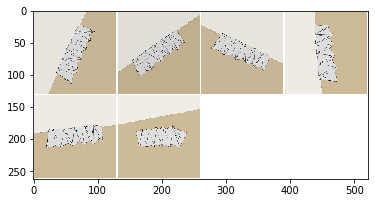

Output of network (To be verified with)


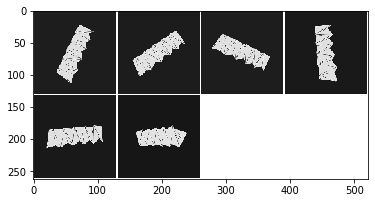

In [38]:
iterator = iter(train_loader)
sample = iterator.next()
augmented,original = sample['augmented'],sample['original']

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
images_show = 8
print('Input to network')
imshow(torchvision.utils.make_grid(augmented[:images_show,:], nrow=4, padding=2, pad_value=1))
print('Output of network (To be verified with)')
imshow(torchvision.utils.make_grid(original[:images_show,:], nrow=4, padding=2, pad_value=1))

In [9]:
def train(model, device, train_loader, optimizer, epoch,log_interval=10):
    model.train()
    for batch_idx, sample in enumerate(train_loader):
        data, target = sample['augmented'],sample['original']
        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch,loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for c, sample in enumerate(test_loader):
            data, target = sample['augmented'],sample['original']
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.binary_cross_entropy(output,target) # sum up batch loss
    test_loss /= max(1,c)

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))

model = AugmentedAutoencoder().to(device)
model.load_state_dict(torch.load('AE.pt'))
optimizer = optim.Adadelta(model.parameters(), lr=15)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)


In [39]:
epochs = 500

for epoch in tqdm(range(1, epochs + 1), unit='epochs'):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, train_loader)

Train Epoch: 1 	Loss: 0.345028

Test set: Average loss: 0.3442

Train Epoch: 2 	Loss: 0.344200

Test set: Average loss: 0.3440

Train Epoch: 3 	Loss: 0.344001

Test set: Average loss: 0.3438

Train Epoch: 4 	Loss: 0.343799

Test set: Average loss: 0.3437

Train Epoch: 5 	Loss: 0.343720

Test set: Average loss: 0.3436

Train Epoch: 6 	Loss: 0.343630

Test set: Average loss: 0.3436

Train Epoch: 7 	Loss: 0.343589

Test set: Average loss: 0.3435

Train Epoch: 8 	Loss: 0.343543

Test set: Average loss: 0.3435

Train Epoch: 9 	Loss: 0.343520

Test set: Average loss: 0.3435

Train Epoch: 10 	Loss: 0.343495

Test set: Average loss: 0.3435

Train Epoch: 11 	Loss: 0.343481

Test set: Average loss: 0.3435

Train Epoch: 12 	Loss: 0.343466

Test set: Average loss: 0.3435

Train Epoch: 13 	Loss: 0.343457

Test set: Average loss: 0.3434

Train Epoch: 14 	Loss: 0.343447

Test set: Average loss: 0.3434

Train Epoch: 15 	Loss: 0.343441

Test set: Average loss: 0.3434

Train Epoch: 16 	Loss: 0.343435

T

KeyboardInterrupt: 

In [40]:
save_model = True

if save_model:
    torch.save(model.state_dict(), 'AE.pt')

In [41]:
def cross_validation(model, device, test_loader,viewer=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        validator = iter(test_loader)
        sample = next(validator)
        data, target = sample['augmented'],sample['original']
        
        data, target = data.to(device), target.to(device)
        output = model(data)
        encodings = model.encoder_op(data)
        

    if viewer:
        images_show = 8
        
        print('Reconstructed')
        op = output[:images_show,:].cpu()
        imshow(torchvision.utils.make_grid(op, nrow=4, padding=2, pad_value=1))
                
        print('Input to Netowrk')
        imshow(torchvision.utils.make_grid(data[:images_show,:].cpu(), nrow=4, padding=2, pad_value=1))  
        
        print('Ground Truth')
        imshow(torchvision.utils.make_grid(target[:images_show,:].cpu(), nrow=4, padding=2, pad_value=1))

    return data,target, output, encodings

Reconstructed


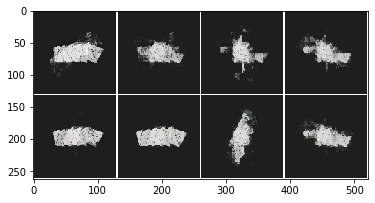

Input to Netowrk


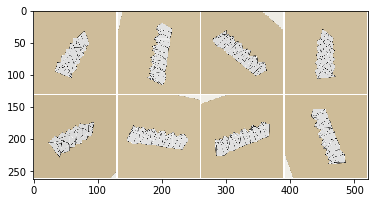

Ground Truth


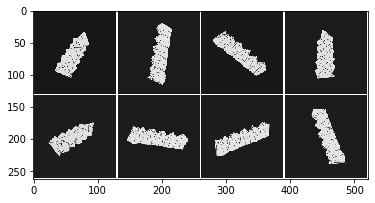

In [43]:
origami_test_dir = "small_data/s_test"
inp='in'
out='out'

trns = transforms.Compose([Resize((128,128)), Normalize(),ToTensor() ])

origami_test = OrigamiDatasetGenerate(root_dir=origami_test_dir,inp=inp, out=out, transform=trns)

val_loader = DataLoader(origami_test, batch_size=train_batch_size,
                            shuffle=True,**kwargs)

input_network, target, output,encodings = cross_validation(model, device, val_loader,viewer=True)

In [30]:
# enc_size = encodings.shape[0]
# def cos(x,y):
#     n = torch.mul(x,y)
#     d = torch.norm(x)*torch.norm(y)
#     return n/d

# a = torch.from_numpy(np.zeros((enc_size,enc_size)))
# for i in range(enc_size):
#     for j in range(enc_size):
#         a[i,j] = cos(encodings[i],encodings[j])

# print(a)

tensor(4.9354)